# Deep-MINE implementation

## 1. Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

from data import Encoder, DeepMINEDataset
from bow import Vocabulary
from models import init_weights, ImageAutoEncoder, TextAutoEncoder, DeepMINEModel
from evaluation import evaluate

import os
import time
import json
import random
import requests
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

RANDOM_SEED = 2025

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

[nltk_data] Downloading package punkt to /home/vichshir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vichshir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


cuda


## 2. Load data

In [2]:
# feedbacks
df_prime_pantry = pd.read_csv('./data/prime_pantry/prime_pantry.csv')
print(df_prime_pantry.shape)

# products
df_products = pd.read_csv('./data/prime_pantry/products.csv').reset_index()
print(df_products.shape)

# users
df_users = pd.read_csv('./data/prime_pantry/users.csv')
print(df_users.shape)

df_test = df_prime_pantry.sample(frac=1).drop_duplicates('reviewerID')
print(df_test.shape)

df_train = df_prime_pantry[~df_prime_pantry['index'].isin(df_test['index'])]
print(df_train.shape)

(284666, 7)
(8941, 5)
(72969, 2)
(72969, 7)
(211697, 7)


In [3]:
# feedbacks
df_prime_pantry = pd.read_csv('./data/books/feedbacks_test.csv')
print(df_prime_pantry.shape)

# products
df_products = pd.read_csv('./data/books/books_test.csv').reset_index()
print(df_products.shape)

# users
df_users = pd.read_csv('./data/books/users_test.csv')
print(df_users.shape)

df_test = df_prime_pantry.sample(frac=1).drop_duplicates('User-ID')
print(df_test.shape)

df_train = df_prime_pantry[~df_prime_pantry['index'].isin(df_test['index'])]
print(df_train.shape)

(186046, 12)
(5562, 10)
(27772, 4)
(27772, 12)
(158274, 12)


## 3. Pre-processing - Bag of Words

In [4]:
review_vocab = Vocabulary()
review_vocab.fit(df_prime_pantry["Book-Author"])
print(review_vocab.vocab_size())

description_vocab = Vocabulary()
description_vocab.fit(df_prime_pantry["Book-Title"])
print(description_vocab.vocab_size())

df_train['reviewText'] = review_vocab.preprocess(df_train['Book-Author'])
df_train['description'] = description_vocab.preprocess(df_train['Book-Title'])

df_test['reviewText'] = review_vocab.preprocess(df_test['Book-Author'])
df_test['description'] = description_vocab.preprocess(df_test['Book-Title'])

Training corpus...
3541
Training corpus...
6471


/tmp/ipykernel_1250/2805010678.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reviewText'] = review_vocab.preprocess(df_train['Book-Author'])
/tmp/ipykernel_1250/2805010678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['description'] = description_vocab.preprocess(df_train['Book-Title'])


## 4. Deep-MINE Model

In [5]:
n_users = df_prime_pantry['User-ID'].nunique()
n_items = df_products['ISBN'].nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)
print('Number of items that has not feedback:', df_products.shape[0] - df_products['ISBN'].isin(df_prime_pantry['ISBN']).sum())

model = DeepMINEModel(
    n_users=n_users,
    n_items=n_items,
    img_size=40,
    review_vocab_size=review_vocab.vocab_size(),
    desc_vocab_size=description_vocab.vocab_size(),
).to(device)
model.apply(init_weights)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of users: 27772
Number of items: 5562
Number of items that has not feedback: 0
Number of parameters: 14749261


## 5. Test evaluation 

In [6]:
test_encoder = Encoder(
    df_test, 
    df_products, 
    df_users, 
    description_vocab, 
    review_vocab, 
    description_key='Book-Title', 
    review_key='Book-Author', 
    users_index_key='index', 
    users_id_key='User-ID', 
    item_id_key='ISBN', 
    item_img_key='Image-URL-M_basename'
)
test_data = DeepMINEDataset(
    df_test, 
    df_products, 
    df_users, 
    n_neg_items=10, 
    users_index_key='index', 
    users_id_key='User-ID', 
    item_id_key='ISBN'
)
test_dataloader = DataLoader(test_data, batch_size=1, collate_fn=test_encoder.process, shuffle=False, num_workers=0)

In [7]:
evaluate(model, test_dataloader, device, topk=1)

  6%|███                                                | 1644/27772 [01:16<20:17, 21.47it/s, hit=0.0906, roc_auc=0.505]


KeyboardInterrupt: 

In [8]:
evaluate(model, test_dataloader, device, topk=5)

  3%|█▋                                                   | 874/27772 [00:38<19:53, 22.53it/s, hit=0.477, roc_auc=0.509]


KeyboardInterrupt: 

## 6. Training

In [9]:
train_encoder = Encoder(df_train, df_products, df_users, description_vocab, review_vocab, users_index_key='index', users_id_key='User-ID', item_id_key='ISBN', item_img_key='Image-URL-M_basename')
training_data = DeepMINEDataset(df_train, df_products, df_users, n_neg_items=1, users_index_key='index', users_id_key='User-ID', item_id_key='ISBN')
train_dataloader = DataLoader(training_data, batch_size=64, collate_fn=train_encoder.process, shuffle=True, num_workers=4)

optim_params = [
    # images
    {
        "params": [model.images_autoencoder.conv1.weight, model.images_autoencoder.conv2.weight, model.images_autoencoder.fc3.weight],
        "weight_decay": model.lambda_w,
    },
    {
        "params": [model.images_autoencoder.conv1.bias, model.images_autoencoder.conv2.bias, model.images_autoencoder.fc3.bias],
        "weight_decay": model.lambda_b,
    },
    # descriptions
    {
        "params": [model.descriptions_autoencoder.fc1.weight, model.descriptions_autoencoder.fc2.weight],
        "weight_decay": model.lambda_q,
    },
    {
        "params": [model.descriptions_autoencoder.fc1.bias, model.descriptions_autoencoder.fc2.bias],
        "weight_decay": model.lambda_c,
    },
    # reviews
    {
        "params": [model.reviews_autoencoder.fc1.weight, model.reviews_autoencoder.fc2.weight],
        "weight_decay": model.lambda_n,
    },
    {
        "params": [model.reviews_autoencoder.fc1.bias, model.reviews_autoencoder.fc2.bias],
        "weight_decay": model.lambda_t,
    },
    # user perception factors
    {
        "params": [model.u_users.weight, model.theta_users.weight],
        "weight_decay": model.lambda_theta,
    },
    # hidden information factor
    {
        "params": [model.v_items.weight],
        "weight_decay": model.lambda_theta,
    },
    # biases
    {
        "params": [model.alpha_users.weight, model.beta_items.weight],
        "weight_decay": model.lambda_beta,
    },
    # embedding layer of information integration
    {
        "params": [model.embeddings.weight],
        "weight_decay": model.lambda_Wfu,
    },
    # cognition factors
    {
        "params": [model.a_1.weight, model.a_2.weight, model.a_3.weight],
        "weight_decay": model.lambda_Wfu,
    },
]

# optim_params = [
#  {
#      "params": [
#          model.images_autoencoder.conv1.weight, model.images_autoencoder.conv2.weight, model.images_autoencoder.fc3.weight,
#          model.images_autoencoder.conv1.bias, model.images_autoencoder.conv2.bias, model.images_autoencoder.fc3.bias,
#          model.descriptions_autoencoder.fc1.weight, model.descriptions_autoencoder.fc2.weight,
#          model.descriptions_autoencoder.fc1.bias, model.descriptions_autoencoder.fc2.bias,
#          model.reviews_autoencoder.fc1.weight, model.reviews_autoencoder.fc2.weight,
#          model.reviews_autoencoder.fc1.bias, model.reviews_autoencoder.fc2.bias
#      ],
#  }   
# ]

# optim_params = [
#  {
#      "params": [
#          model.u_users.weight, model.theta_users.weight,
#          model.v_items.weight,
#          model.alpha_users.weight, model.beta_items.weight,
#          model.embeddings.weight,
#          model.a_1.weight, model.a_2.weight, model.a_3.weight
#      ],
#  }   
# ]

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

loss_history = []
for epoch in range(3):
    model.train()
    running_loss = 0.0
    running_sys_loss = 0.0
    running_ae_loss = 0.0
    for idx, data in enumerate(pbar := tqdm(train_dataloader)):
        optimizer.zero_grad()
        user_id = data['user_ids']
        positive_item = data['pos_item']
        negative_item = data['neg_item']

        p_item, p_image, p_description, p_review = positive_item['ids'], positive_item['images'], positive_item['descriptions'], positive_item['reviews']
        n_item, n_image, n_description, n_review = negative_item['ids'], negative_item['images'], negative_item['descriptions'], negative_item['reviews']

        loss, outputs, (sys_loss, ae_loss) = model(
            user_id.to(device),
            p_item.to(device),
            p_image.to(device),
            p_description.to(device),
            p_review.to(device),
            n_item.to(device),
            n_image.to(device),
            n_description.to(device),
            n_review.to(device)
        )

        loss.backward()

        # step the optimizer
        optimizer.step()

        running_loss += loss.item()
        running_sys_loss += sys_loss.item()
        running_ae_loss += ae_loss.item()
        pbar.set_postfix(loss=running_loss/(idx+1), sys_loss=running_sys_loss/(idx+1), ae_loss=running_ae_loss/(idx+1))
        pbar.update()

        loss_history.append(loss.item())

/home/vichshir/miniconda3/envs/bamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 53%|████████████████████▋                  | 1316/2474 [05:47<05:06,  3.78it/s, ae_loss=0.0962, loss=43.1, sys_loss=43]


KeyboardInterrupt: 

## 7. Evaluation

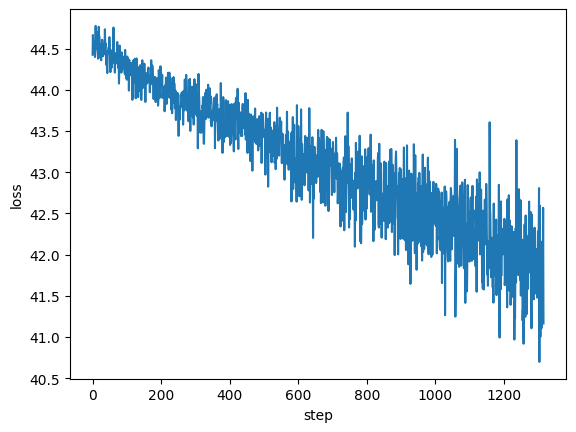

In [10]:
sns.lineplot(loss_history)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [11]:
evaluate(model, test_dataloader, device, topk=1)

  3%|█▉                                                    | 971/27772 [00:42<19:45, 22.61it/s, hit=0.42, roc_auc=0.801]


KeyboardInterrupt: 

In [12]:
evaluate(model, test_dataloader, device, topk=5)

  2%|█▏                                                   | 619/27772 [00:27<20:01, 22.60it/s, hit=0.824, roc_auc=0.803]


KeyboardInterrupt: 

TODO:
- Progress bar: why there's more iterations after 100%?
- Dataloader: __getitem__ problem?